In [2]:
library(tidyverse)

theme_set(theme_minimal())

options(repr.plot.width = 7, repr.plot.height = 8, repr.plot.res = 240,
        readr.show_col_types = F)

df <- read_rds("data/us_excess_deaths_per_age_group.rds")%>%
  na.omit()

head(df)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



,Jurisdiction,Age Group,Year,Week,Number of Deaths,Type,Date,Population,Population_all_ages,Population_age_group_nation
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>
1,Alabama,<65,2018,37,285.3385,Predicted,2018-09-16,4033195,4907439,272637837
2,Alabama,<65,2018,38,288.3385,Predicted,2018-09-23,4033195,4907439,272637837
3,Alabama,<65,2018,35,288.1385,Predicted,2018-09-02,4033195,4907439,272637837
4,Alabama,<65,2018,36,288.1385,Predicted,2018-09-09,4033195,4907439,272637837
5,Alabama,<65,2018,50,311.9385,Predicted,2018-12-16,4033195,4907439,272637837
6,Alabama,<65,2018,51,320.3385,Predicted,2018-12-23,4033195,4907439,272637837


The formula for population adjusted mortality: 

$$\sum_{age} {\frac{deaths_{age}^{state}}{pop^{state} }  \cdot 10^{6}}$$


The formula for age adjusted mortality: 
$$\sum_{age} { \frac{deaths_{age}^{state}}{pop_{age}^{state} } \cdot \frac{pop_{age}^{US} }{pop^{US}} \cdot 10^{6} }$$

In [8]:
pop_us_m = 328.3

df1<-
  df%>%
  spread(Type, `Number of Deaths`)%>%
  filter(Date>="2020-02-01" & Date<"2021-02-01")%>%
  na.omit()%>%
  group_by(Jurisdiction, `Age Group`)%>%
  #summarise(`Excess Deaths`  = sum((Observed-Predicted)/Population_all_ages*1000000))%>%
  summarise(`Excess Deaths`  = sum((Observed-Predicted)/Population*Population_age_group_nation/pop_us_m))%>%
  mutate(Year = "Year one")

df2<-
  df%>%
  spread(Type, `Number of Deaths`)%>%
  filter(Date>="2021-02-01" & Date<"2022-02-01")%>%
  na.omit()%>%
  group_by(Jurisdiction, `Age Group`)%>%
  #summarise(`Excess Deaths` =  sum((Observed-Predicted)/Population_all_ages*1000000))%>%
  summarise(`Excess Deaths`  = sum((Observed-Predicted)/Population*Population_age_group_nation/pop_us_m))%>%
  mutate(Year = "Year two")

df_all <- rbind(df1, df2)%>%
  merge(read_csv("data/state_party.csv"), all = T)
head(df_all)

`summarise()` has grouped output by 'Jurisdiction'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Jurisdiction'. You can override using the
`.groups` argument.


,Jurisdiction,Year,Age Group,Excess Deaths,party
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,Alabama,Year one,85+,591.4716,republican
2,Alabama,Year one,75-84,595.0084,republican
3,Alabama,Year one,<65,738.8332,republican
4,Alabama,Year one,65-74,473.5796,republican
5,Alabama,Year two,<65,1131.2905,republican
6,Alabama,Year two,65-74,505.5933,republican


`summarise()` has grouped output by 'Jurisdiction'. You can override using the
`.groups` argument.


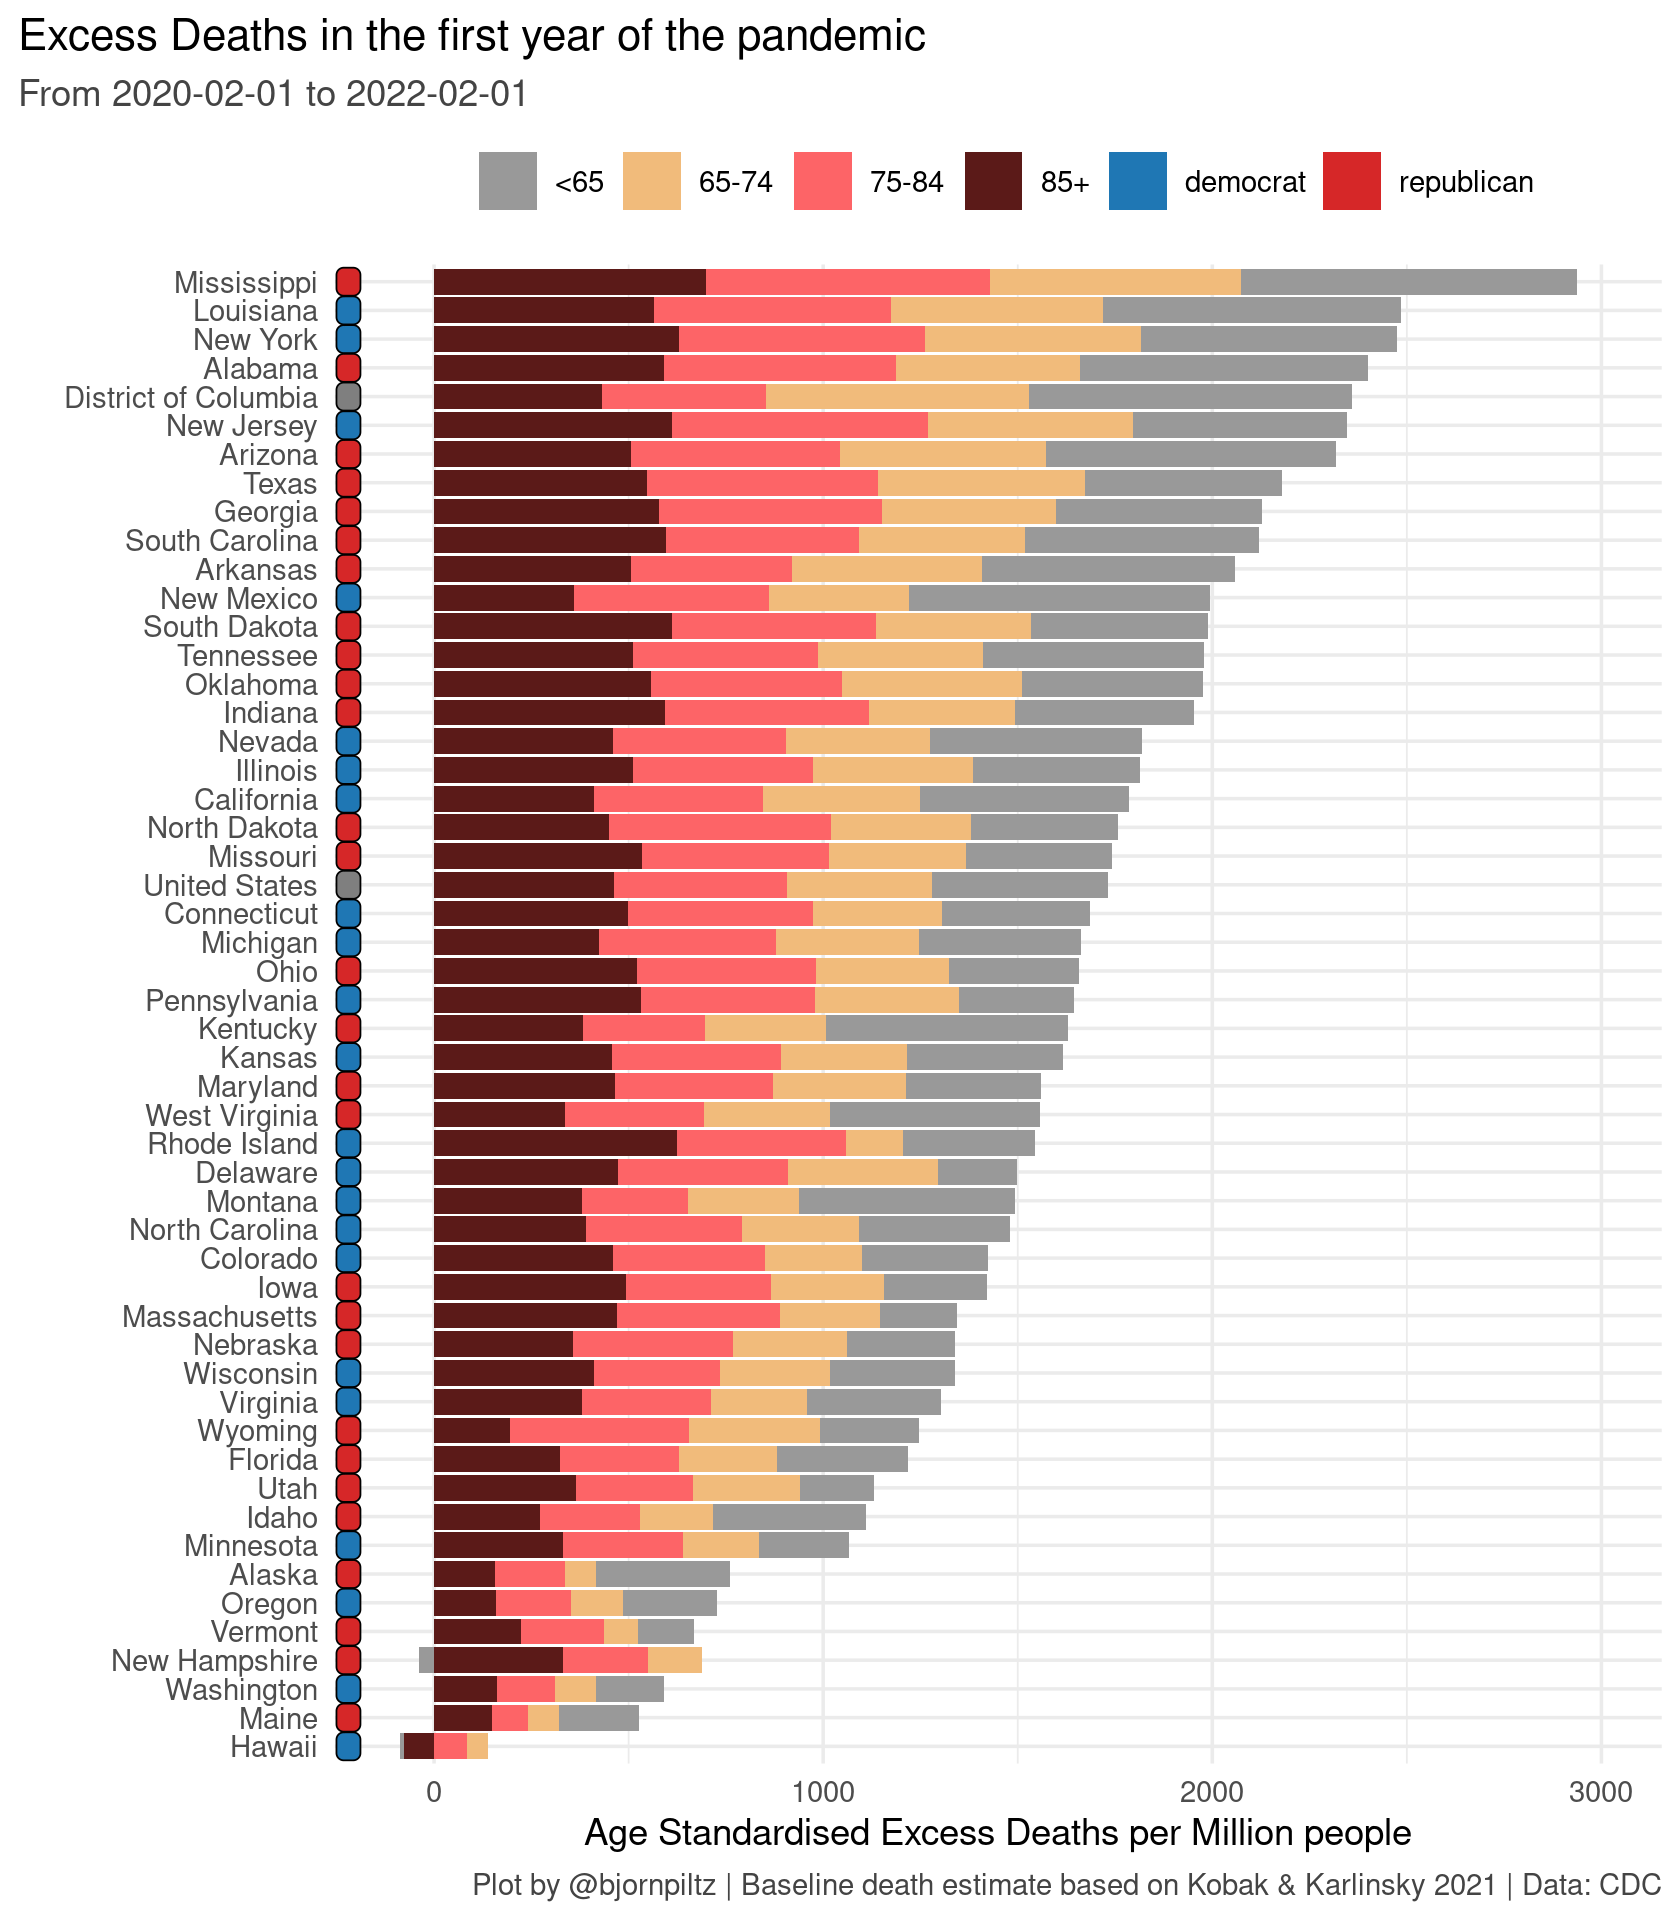

In [4]:
order_by_year1 = (df1%>%group_by(Jurisdiction)%>%summarise(`Excess Deaths`= sum(`Excess Deaths`))%>%arrange(`Excess Deaths`))$Jurisdiction

df_all%>%
  filter(Year=="Year one")%>%
  mutate(Jurisdiction = factor(Jurisdiction, levels = order_by_year1))%>%
  ggplot(aes(x = Jurisdiction, y = `Excess Deaths`, fill = `Age Group`)) +
  labs(title = "Excess Deaths in the first year of the pandemic",
       subtitle = "From 2020-02-01 to 2022-02-01", fill = "", 
       x = "", y = "Age Standardised Excess Deaths per Million people",
       caption = "Plot by @bjornpiltz | Baseline death estimate based on Kobak & Karlinsky 2021 | Data: CDC") +
  geom_col() +
  coord_flip(ylim = c(-100, 3000), clip = "off") + 
  scale_fill_manual(values = c('#999999', '#F1BB7B', '#FD6467', '#5B1A18', "#1F77B4", "#D62728"),
                   guide = guide_legend(nrow = 1)) +
  theme(legend.position = "top",
        plot.title.position = "plot",
        plot.subtitle=element_text(color = '#444444'),
        plot.caption=element_text(color = '#444444')) +
  geom_label(data = df_all%>%
                      filter(Year=="Year one")%>%
                      group_by(Jurisdiction, party)%>%
                      summarise(tmp = 0),
    aes(fill = party), label = "", size = .5, y = -220)

`summarise()` has grouped output by 'Jurisdiction', 'party'. You can override
using the `.groups` argument.


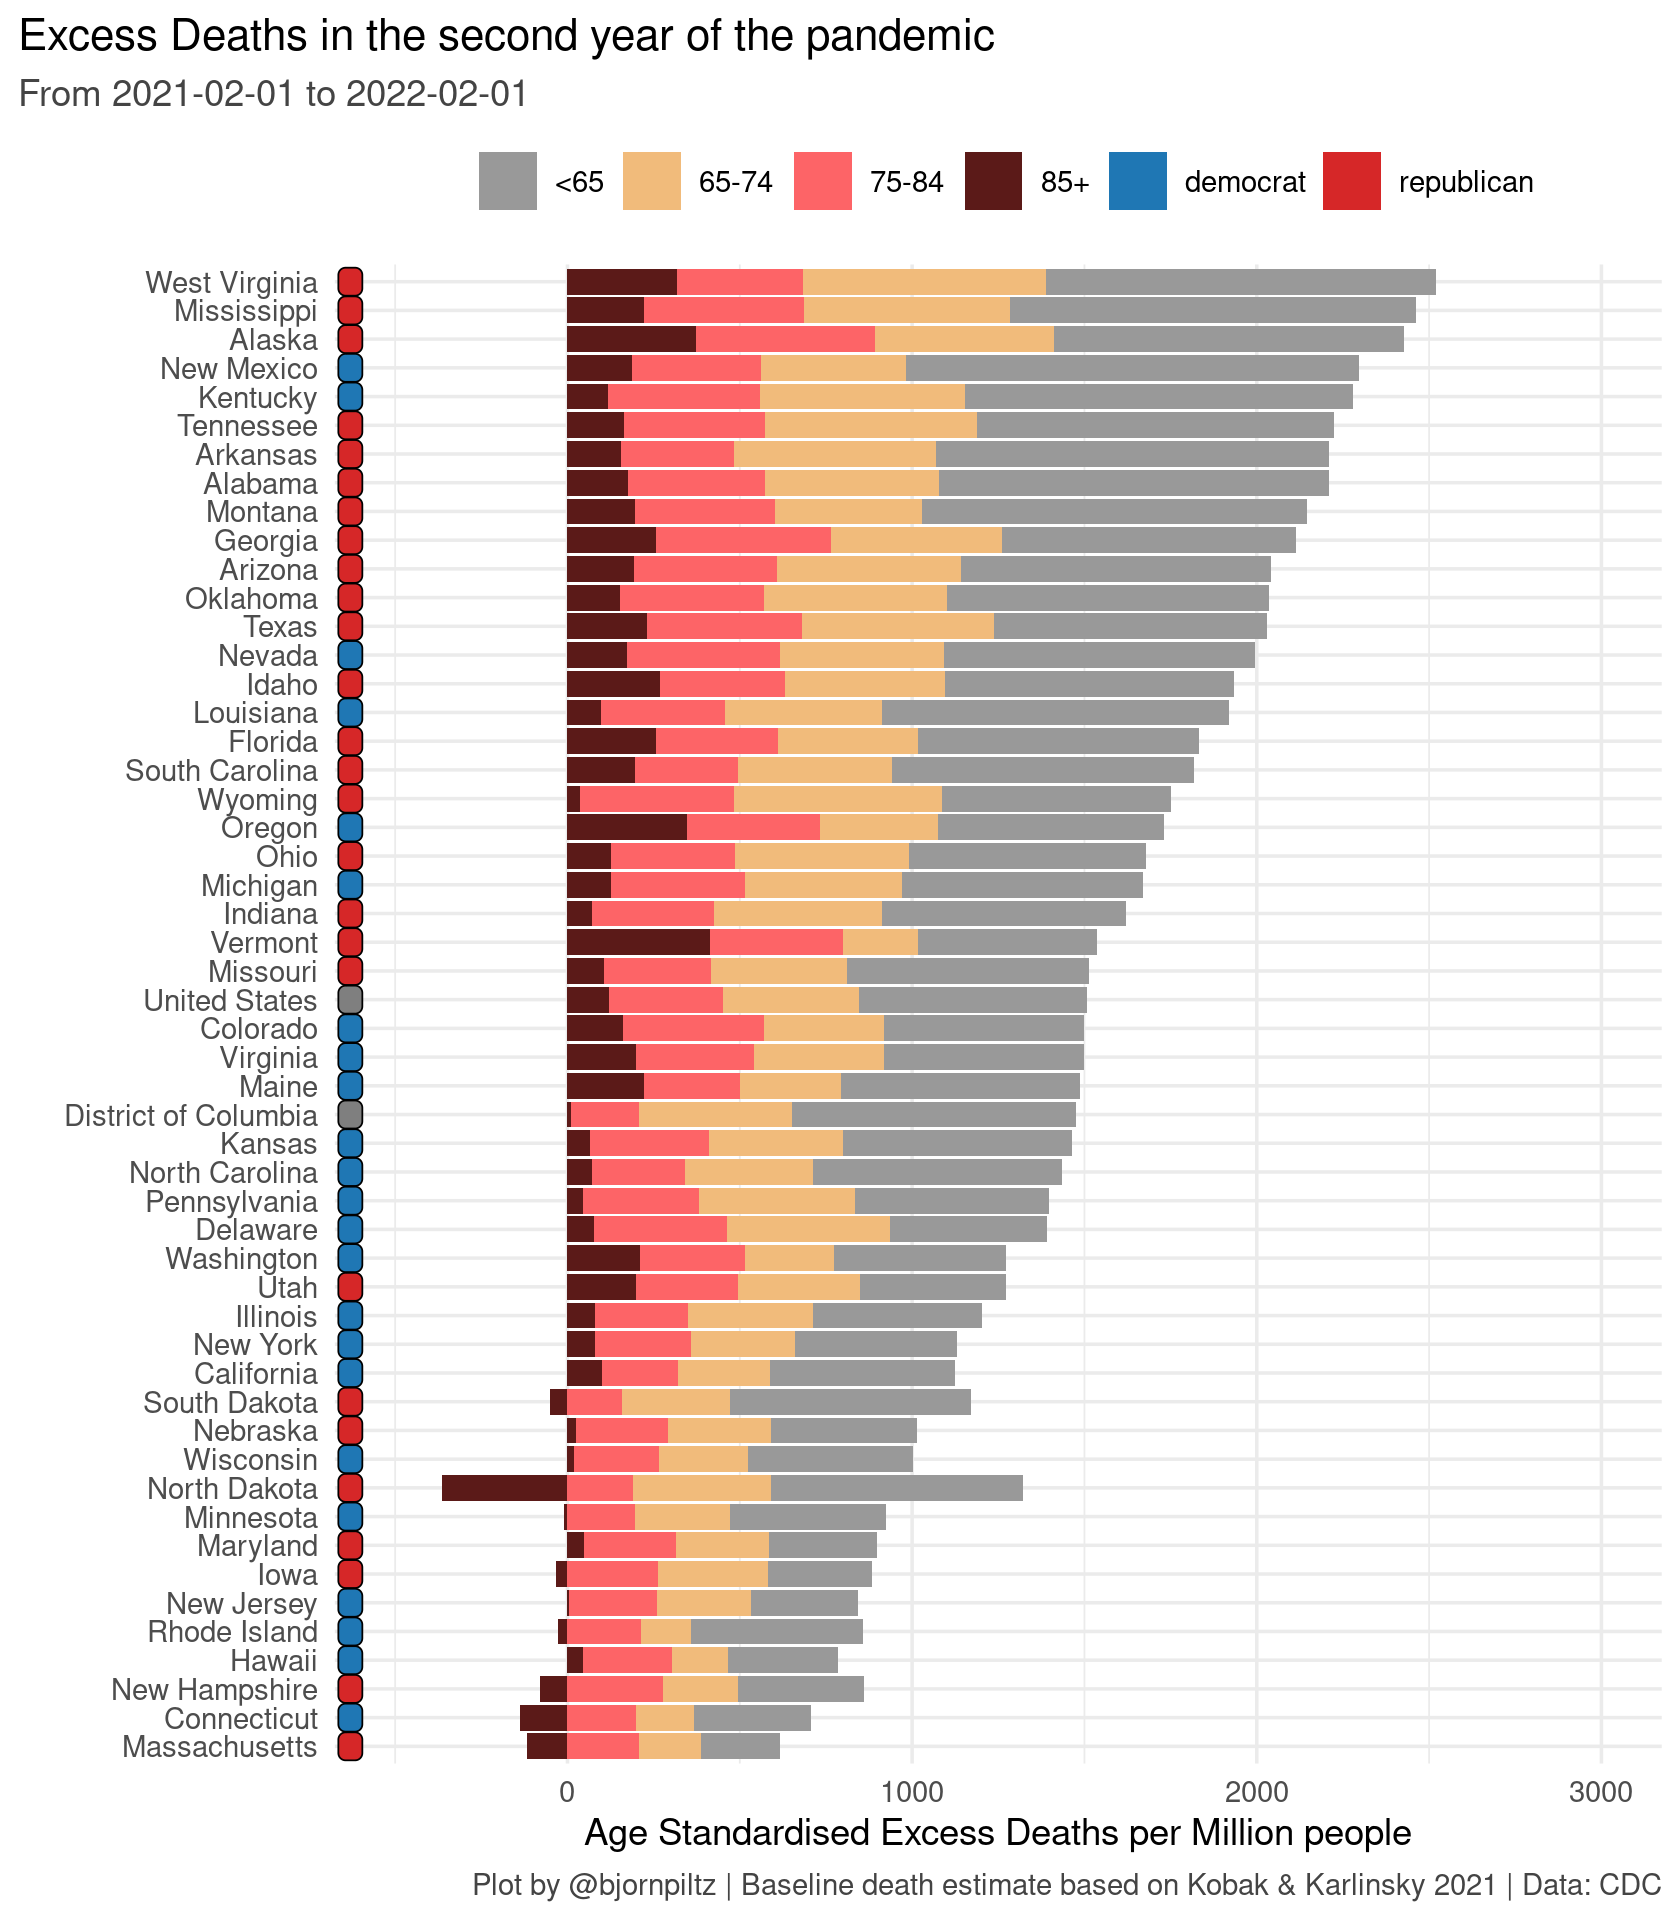

In [5]:
order_by_year2 = (df2%>%group_by(Jurisdiction)%>%summarise(`Excess Deaths`= sum(`Excess Deaths`))%>%arrange(`Excess Deaths`))$Jurisdiction

df_all%>%
  filter(Year=="Year two")%>%
  mutate(Jurisdiction = factor(Jurisdiction, levels = order_by_year2))%>%
  ggplot(aes(x = Jurisdiction, y = `Excess Deaths`, fill = `Age Group`)) + 
  labs(title = "Excess Deaths in the second year of the pandemic",
       subtitle = "From 2021-02-01 to 2022-02-01",
       caption = "Plot by @bjornpiltz | Baseline death estimate based on Kobak & Karlinsky 2021 | Data: CDC", 
       x = "", y = "Age Standardised Excess Deaths per Million people", fill = "") +
  geom_col() +
  coord_flip(ylim = c(-500, 3000), clip = "off") + 
  scale_fill_manual(values = c('#999999', '#F1BB7B', '#FD6467', '#5B1A18', "#1F77B4", "#D62728"),
                   guide = guide_legend(nrow = 1)) +
  theme(legend.position = "top",
        plot.title.position = "plot",
        plot.subtitle=element_text(color = '#444444'),
        plot.caption=element_text(color = '#444444')) +
  geom_label(data = df_all%>%
                      filter(Year=="Year two")%>%
                      group_by(Jurisdiction, party, percD)%>%
                      summarise(tmp = 0), show.legend = T,
    aes(fill = party), label = "", size = .5, y = -630)

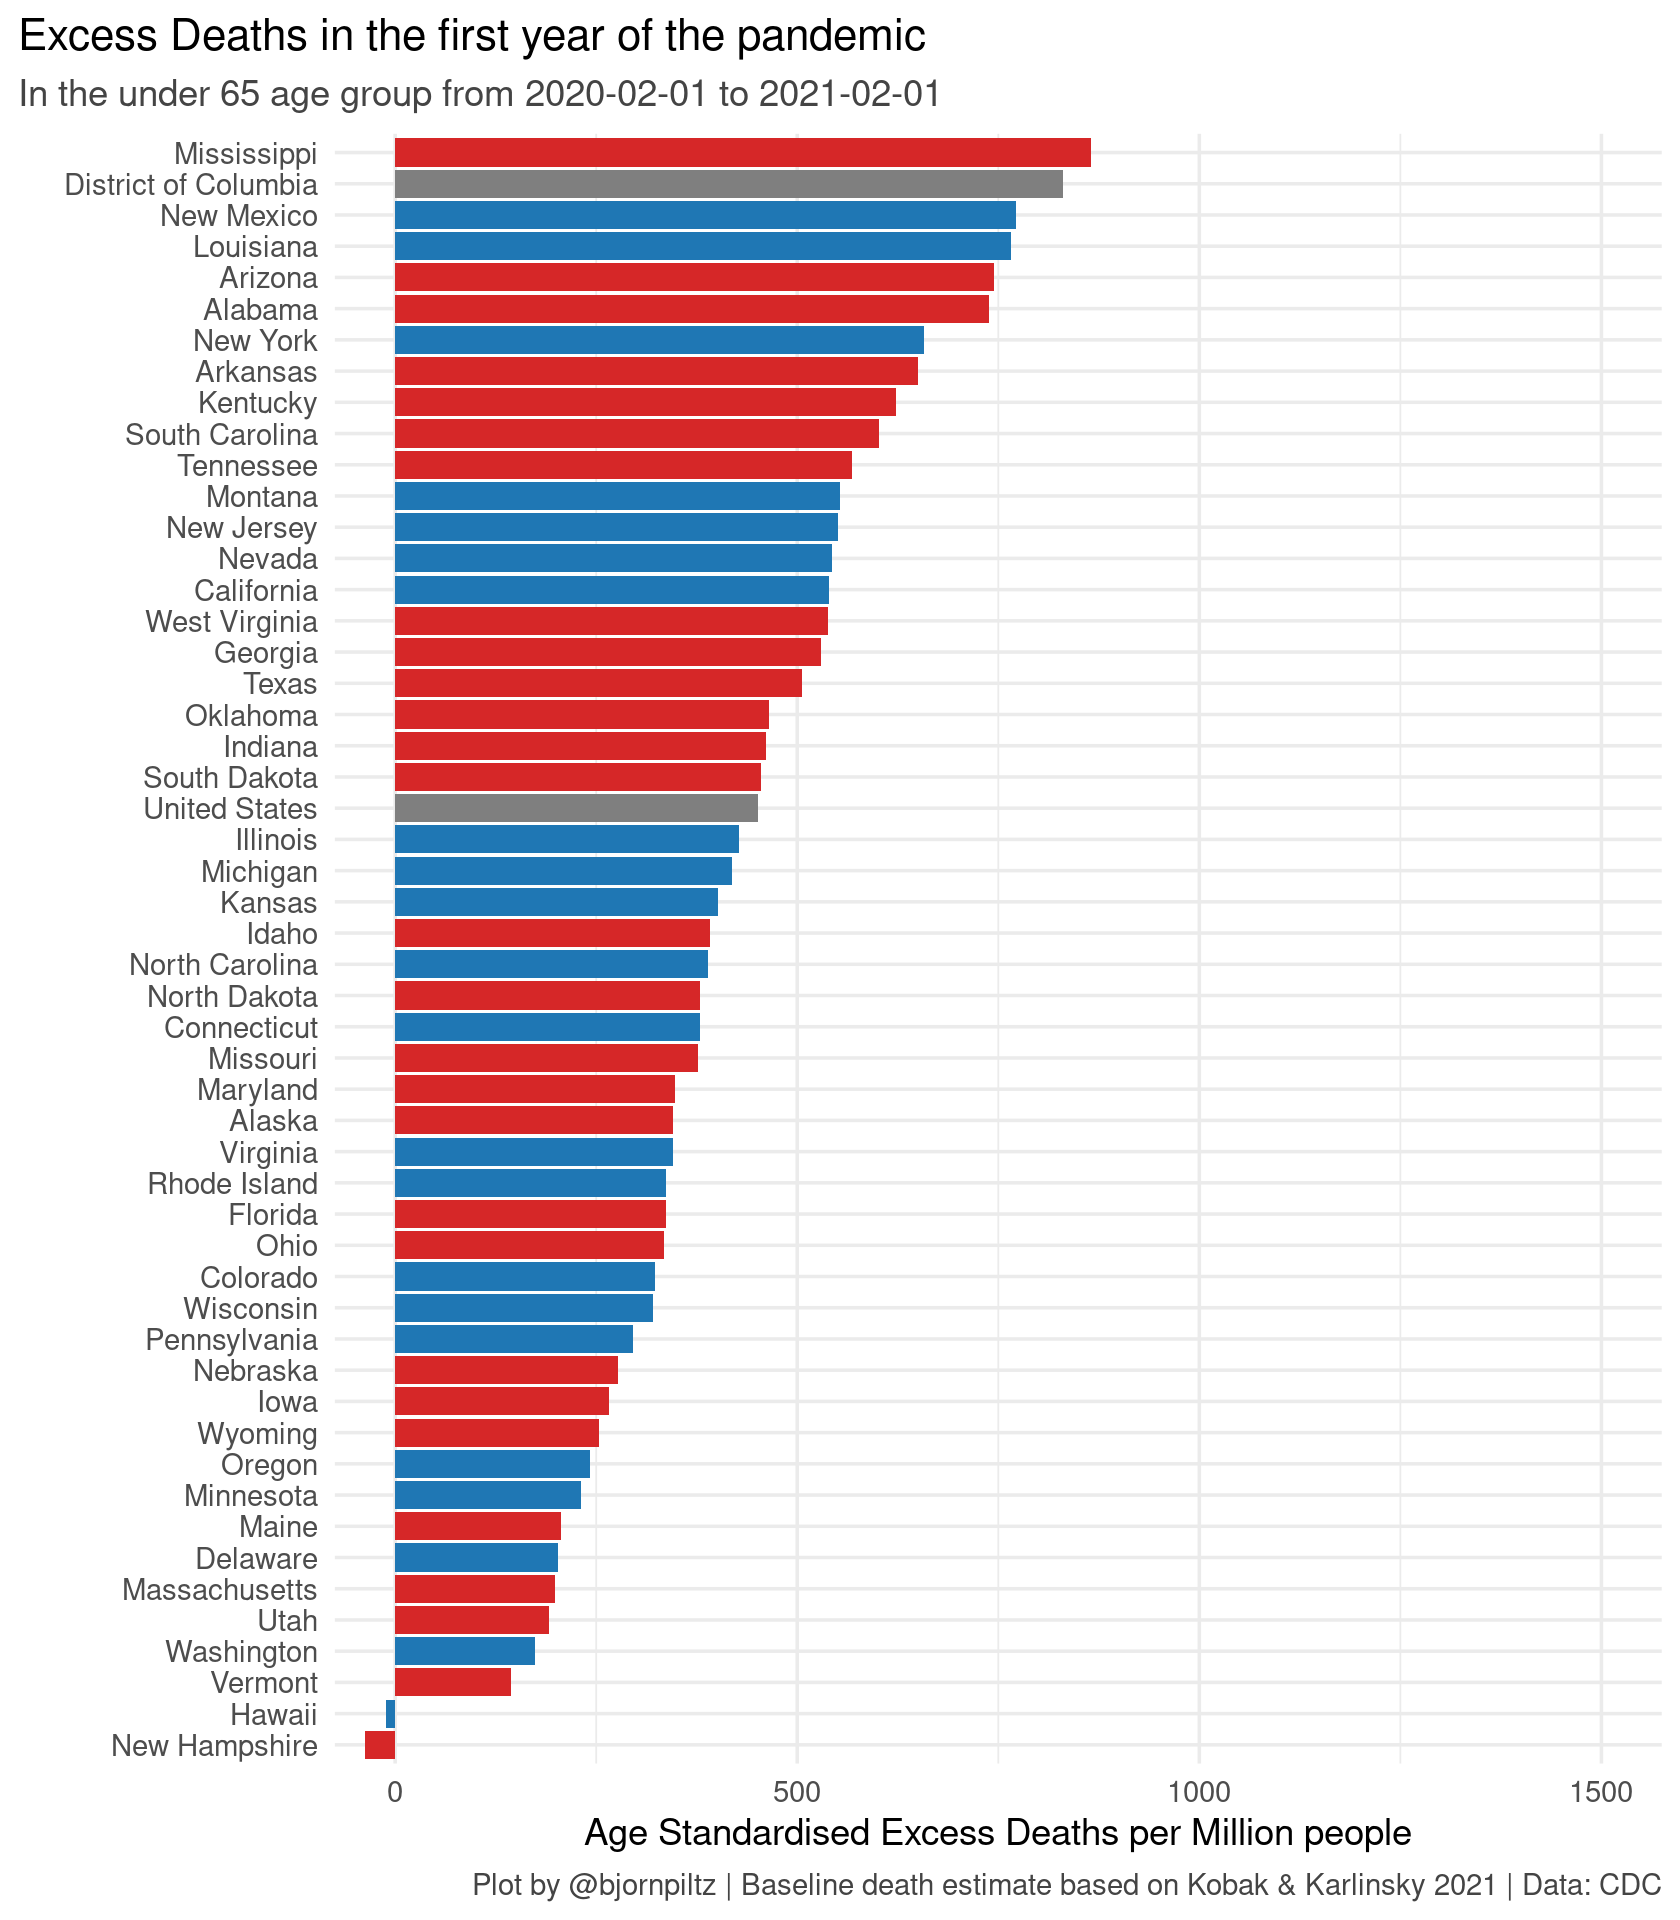

In [6]:
order_by_year1_u65 = (df1%>%filter(`Age Group`=="<65")%>%group_by(Jurisdiction)%>%summarise(`Excess Deaths`= sum(`Excess Deaths`))%>%arrange(`Excess Deaths`))$Jurisdiction

df_all%>%
  filter(Year=="Year one")%>%
  filter(`Age Group`=="<65")%>%
  mutate(Jurisdiction = factor(Jurisdiction, levels = order_by_year1_u65))%>%
  ggplot(aes(x = Jurisdiction, y = `Excess Deaths`, fill = party)) +
  labs(title = "Excess Deaths in the first year of the pandemic",
       subtitle = "In the under 65 age group from 2020-02-01 to 2021-02-01",
      caption = "Plot by @bjornpiltz | Baseline death estimate based on Kobak & Karlinsky 2021 | Data: CDC", 
       x = "", y = "Age Standardised Excess Deaths per Million people", fill = "") +
  geom_col() +
  coord_flip(ylim = c(0, 1500), clip = "off") + 
  scale_fill_manual(values = c("#1F77B4", "#D62728")) +
  theme(legend.position = "none",
        plot.title.position = "plot",
        plot.subtitle=element_text(color = '#444444'),
        plot.caption=element_text(color = '#444444'))

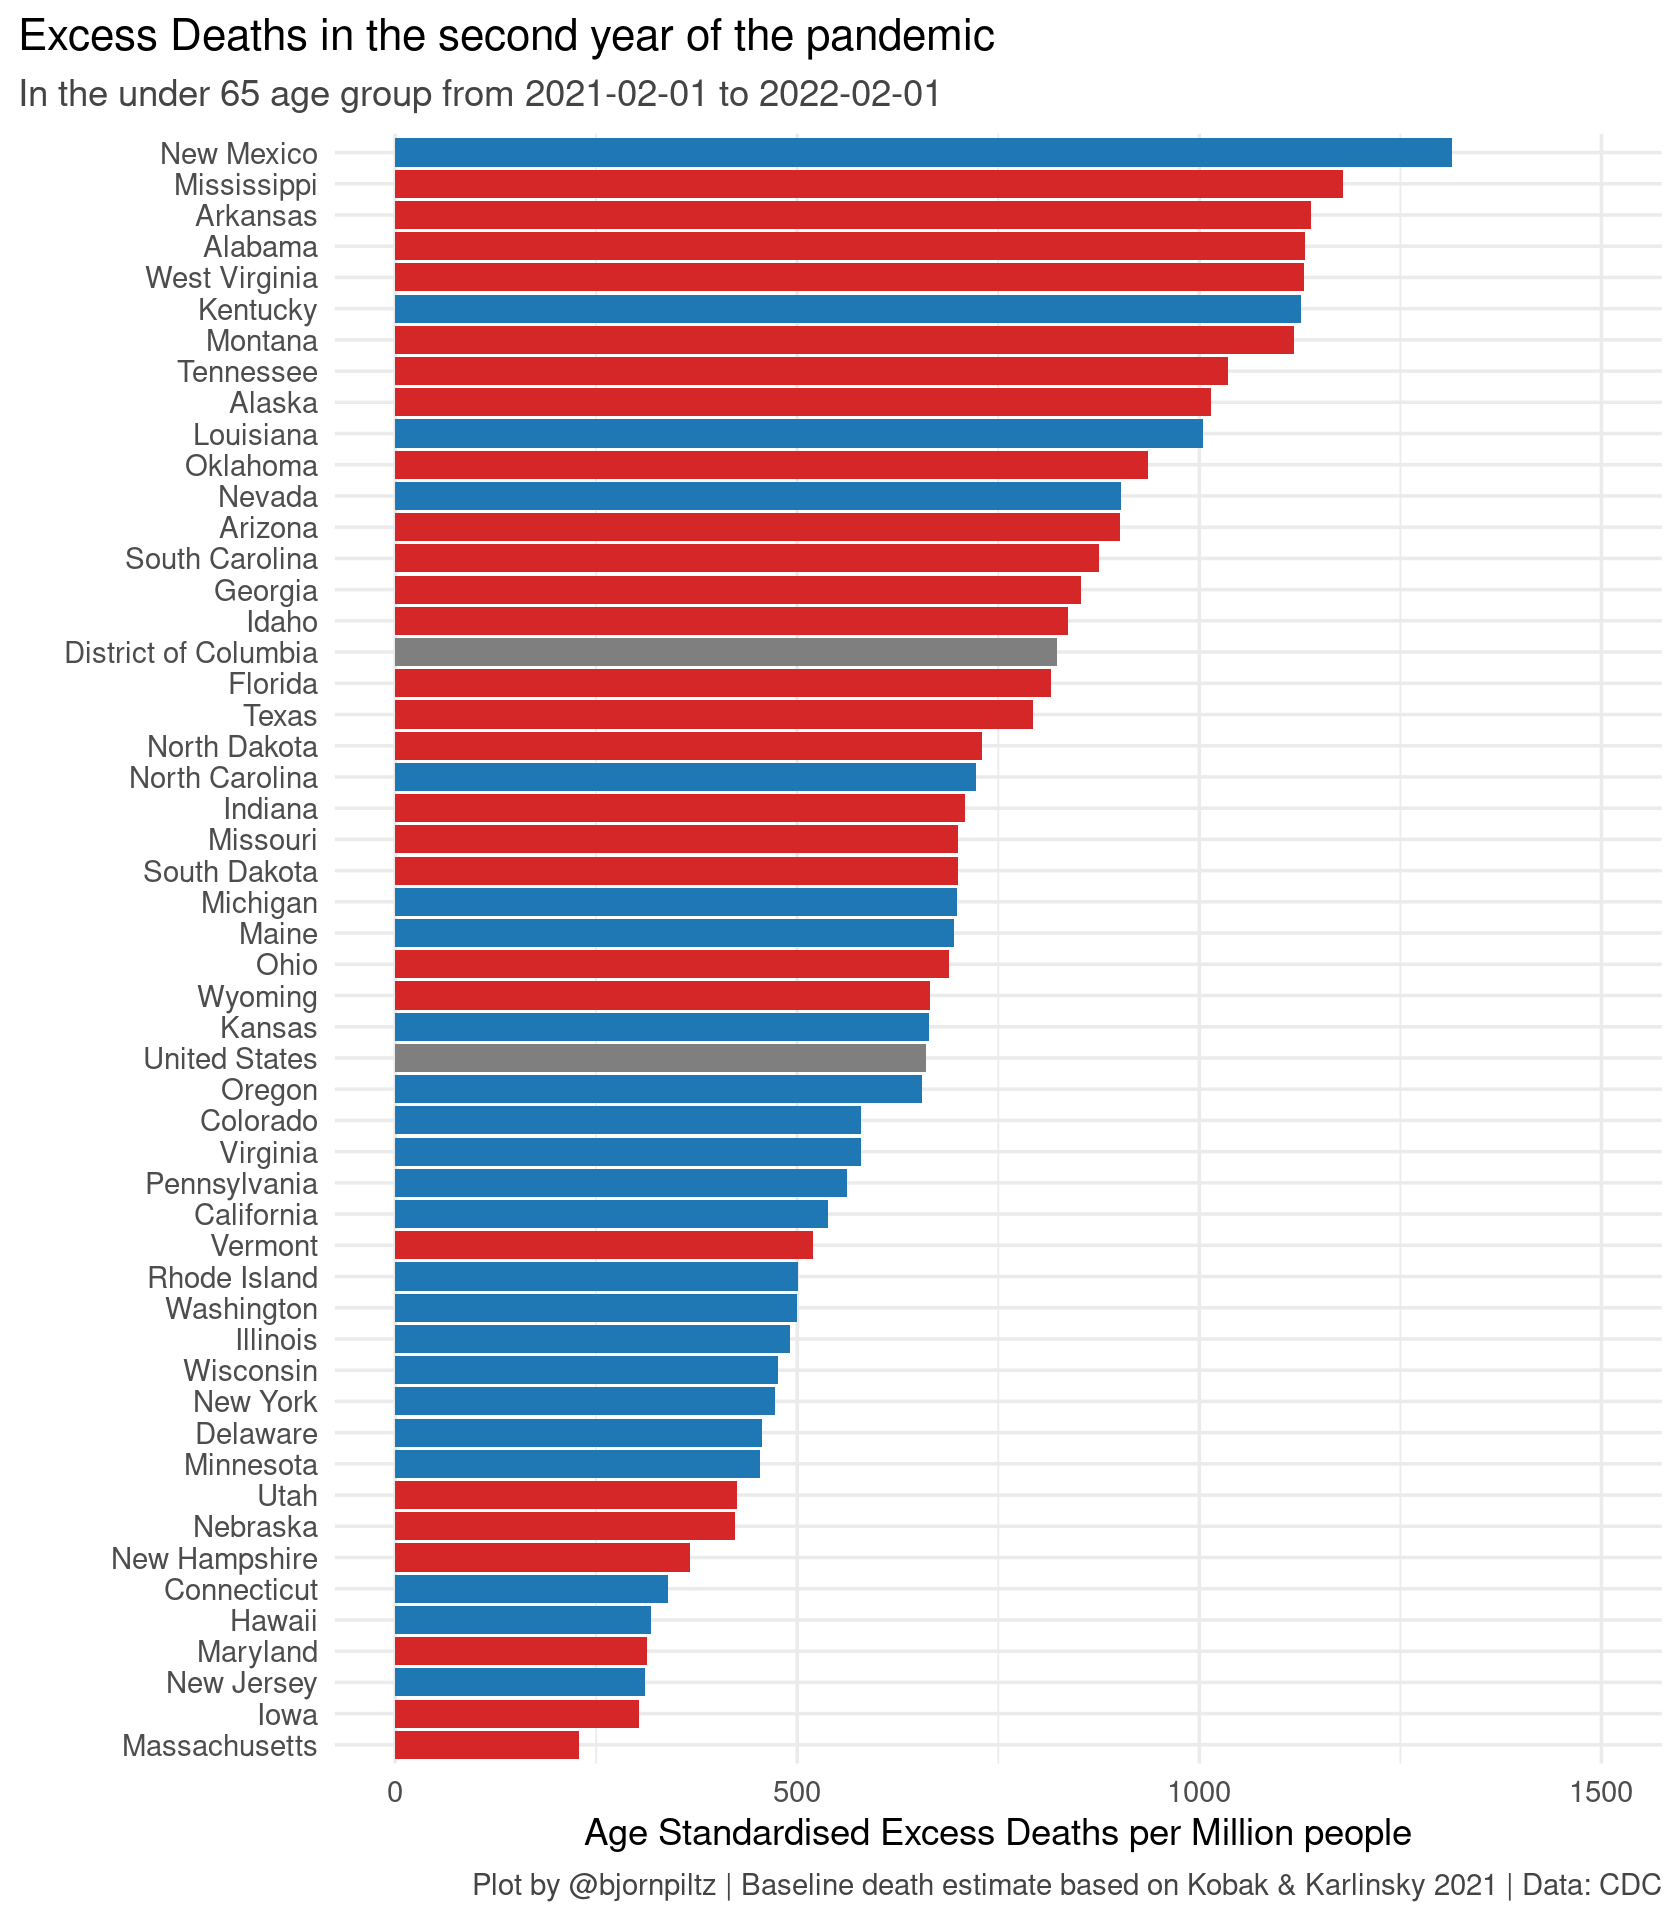

In [9]:
options(repr.plot.width = 7, repr.plot.height = 8, repr.plot.res = 240)

order_by_year2_u65 = (df2%>%filter(`Age Group`=="<65")%>%group_by(Jurisdiction)%>%summarise(`Excess Deaths`= sum(`Excess Deaths`))%>%arrange(`Excess Deaths`))$Jurisdiction

df_all%>%
  filter(Year=="Year two")%>%
  filter(`Age Group`=="<65")%>%
  mutate(Jurisdiction = factor(Jurisdiction, levels = order_by_year2_u65))%>%
  ggplot(aes(x = Jurisdiction, y = `Excess Deaths`, fill = party)) +
  labs(title = "Excess Deaths in the second year of the pandemic",
       subtitle = "In the under 65 age group from 2021-02-01 to 2022-02-01",
       caption = "Plot by @bjornpiltz | Baseline death estimate based on Kobak & Karlinsky 2021 | Data: CDC", 
       x = "", y = "Age Standardised Excess Deaths per Million people", fill = "") +
  geom_col() +
  coord_flip(ylim = c(0, 1500), clip = "off") + 
  scale_fill_manual(values = c("#1F77B4", "#D62728")) +
  theme(legend.position = "none",
        plot.title.position = "plot",
        plot.subtitle=element_text(color = '#444444'),
        plot.caption=element_text(color = '#444444'))